# Spherical grids and UnitConversion


In most applications, Parcels works with `spherical` meshes, where longitude and latitude are given in degrees, while depth is given in meters. But it is also possible to use `flat` meshes, where longitude and latitude are given in meters (note that the dimensions are then still called `longitude` and `latitude` for consistency reasons).

In all cases, velocities are given in m/s. So Parcels seamlessly converts between meters and degrees, under the hood. For transparency, this tutorial explain how this works.


Let's first import the relevant modules, and create dictionaries for the `U`, `V` and `temp` data arrays, with the velocities 1 m/s and the temperature 20C.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from parcels import Field, FieldSet

In [2]:
xdim, ydim = (10, 20)
data = {
    "U": np.ones((ydim, xdim), dtype=np.float32),
    "V": np.ones((ydim, xdim), dtype=np.float32),
    "temp": 20 * np.ones((ydim, xdim), dtype=np.float32),
}
dims = {
    "lon": np.linspace(-15, 5, xdim, dtype=np.float32),
    "lat": np.linspace(35, 60, ydim, dtype=np.float32),
}

We can convert these data and dims to a FieldSet object using `FieldSet.from_data`. We add the argument `mesh='spherical'` (this is the default option) to signal that all longitudes and latitudes are in degrees.

Plotting the `U` field indeed shows a uniform 1m/s eastward flow.


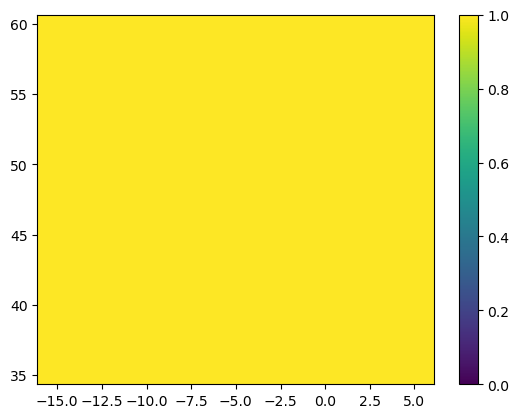

In [3]:
fieldset = FieldSet.from_data(data, dims, mesh="spherical")
plt.pcolormesh(fieldset.U.lon, fieldset.U.lat, fieldset.U.data[0, :, :], vmin=0, vmax=1)
plt.colorbar()
plt.show()

However, printing the velocites directly shows something perhaps surprising. Here, we use the square-bracket field-interpolation notation to print the field value at (5W, 40N, 0m depth) at time 0. _Note that sampling a velocity in Parcels is done by calling the `fieldset.UV` VectorField; see the [Field Sampling tutorial](https://docs.oceanparcels.org/en/latest/examples/tutorial_sampling.html#Sampling-velocity-fields) for more information._


In [4]:
print(fieldset.UV[0, 0, 40, -5])
print(fieldset.temp[0, 0, 40, -5])

(1.1747725785927634e-05, 8.999280057595393e-06)
20.0


While the temperature field indeed is 20C, as we defined, these printed velocities are much smaller.

This is because Parcels converts under the hood from m/s to degrees/s. This conversion is done with a `UnitConverter` object, which is stored in the `.units` attribute of each Field. Below, we print these


In [5]:
for fld in [fieldset.U, fieldset.V, fieldset.temp]:
    print(f"{fld.name}: {fld.units}")

U: <parcels.tools.converters.GeographicPolar object at 0x15f769890>
V: <parcels.tools.converters.Geographic object at 0x15f7698d0>
temp: <parcels.tools.converters.UnitConverter object at 0x16675f010>


So the U field has a `GeographicPolar` UnitConverter object, the V field has a `Geographic` Unitconverter and the `temp` field has a `UnitConverter` object.

Indeed, if we multiply the value of the V field with 1852 \* 60 (the number of meters in 1 degree of latitude), we get the expected 1 m/s.


In [6]:
u, v = fieldset.UV[0, 0, 40, -5]
print(v * 1852 * 60)

1.0000000000000002


Note that you can also interpolate the Field without a unit conversion, by using the `eval()` method and setting `applyConversion=False`, as below


In [7]:
print(fieldset.UV.eval(0, 0, 40, -5, applyConversion=False))

(1.0, 1.0)


## UnitConverters for `mesh='flat'`


If longitudes and latitudes are given in meters, rather than degrees, simply add `mesh='flat'` when creating the FieldSet object.


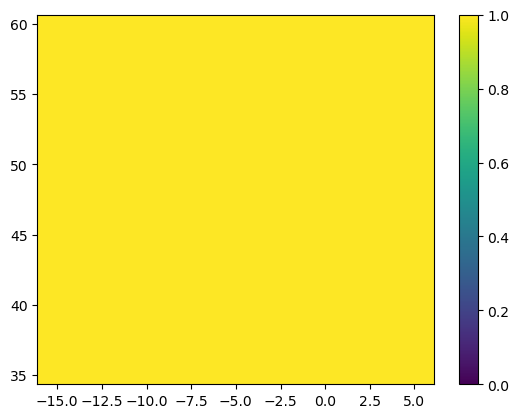

Velocities: (1.0, 1.0)
U: <parcels.tools.converters.UnitConverter object at 0x166810350>
V: <parcels.tools.converters.UnitConverter object at 0x16686cfd0>
temp: <parcels.tools.converters.UnitConverter object at 0x16687a690>


In [8]:
fieldset_flat = FieldSet.from_data(data, dims, mesh="flat")

plt.pcolormesh(
    fieldset_flat.U.lon,
    fieldset_flat.U.lat,
    fieldset_flat.U.data[0, :, :],
    vmin=0,
    vmax=1,
)
plt.colorbar()
plt.show()

print("Velocities:", fieldset_flat.UV[0, 0, 40, -5])
for fld in [fieldset_flat.U, fieldset_flat.V, fieldset_flat.temp]:
    print(f"{fld.name}: {fld.units}")

Indeed, in this case all Fields have the same default `UnitConverter` object.


## UnitConverters for Diffusion fields


The units for Brownian diffusion are in $m^2/s$. If (and only if!) the diffusion fields are called `kh_zonal` and `kh_meridional`, Parcels will automatically assign the correct Unitconverter objects to these fields.


In [9]:
kh_zonal = 100  # in m^2/s
kh_meridional = 100  # in m^2/s

fieldset.add_field(
    Field(
        "Kh_zonal",
        kh_zonal * np.ones((ydim, xdim), dtype=np.float32),
        grid=fieldset.U.grid,
    )
)
fieldset.add_field(
    Field(
        "Kh_meridional",
        kh_meridional * np.ones((ydim, xdim), dtype=np.float32),
        grid=fieldset.U.grid,
    )
)

for fld in [fieldset.Kh_zonal, fieldset.Kh_meridional]:
    print(f"{fld.name}: {fld[0, 0, 40, -5]:e} {fld.units}")

Kh_zonal: 1.380091e-08 <parcels.tools.converters.GeographicPolarSquare object at 0x15f769910>
Kh_meridional: 8.098704e-09 <parcels.tools.converters.GeographicSquare object at 0x15f769950>


Here, the unitconverters are `GeographicPolarSquare` and `GeographicSquare`, respectively.

Indeed, multiplying with $(1852\cdot60)^2$ returns the original value


In [10]:
deg_to_m = 1852 * 60
print(fieldset.Kh_meridional[0, 0, 40, -5] * deg_to_m**2)

100.0


## Adding a UnitConverter object to a Field


So, to summarise, here is a table with all the conversions

| Field name       | Converter object        | Conversion for `mesh='spherical'`                         | Conversion for `mesh='flat'` |
| ---------------- | ----------------------- | --------------------------------------------------------- | ---------------------------- |
| 'U'              | `GeographicPolar`       | $1852 \cdot 60 \cdot \cos(lat \cdot \frac{\pi}{180})$     | 1                            |
| 'V'              | `Geographic`            | $1852 \cdot 60$                                           | 1                            |
| 'Kh_zonal'       | `GeographicPolarSquare` | $(1852 \cdot 60 \cdot \cos(lat \cdot \frac{\pi}{180}))^2$ | 1                            |
| 'Kh_meridional'  | `GeographicSquare`      | $(1852 \cdot 60)^2$                                       | 1                            |
| All other fields | `UnitConverter`         | 1                                                         | 1                            |

Only four Field names are recognised and assigned an automatic UnitConverter object. This means that things might go very wrong when e.g. a velocity field is not called `U` or `V`.

Fortunately, you can always add a UnitConverter later, as explained below:


In [11]:
fieldset.add_field(
    Field("Ustokes", np.ones((ydim, xdim), dtype=np.float32), grid=fieldset.U.grid)
)
print(fieldset.Ustokes[0, 0, 40, -5])

1.0


This value for `Ustokes` of course is not as expected, since the mesh is spherical and hence this would mean 1 degree/s velocity. Assigning the correct `GeographicPolar` Unitconverter gives


In [12]:
from parcels.tools.converters import GeographicPolar

fieldset.Ustokes.units = GeographicPolar()
print(fieldset.Ustokes[0, 0, 40, -5])
print(fieldset.Ustokes[0, 0, 40, -5] * 1852 * 60 * np.cos(40 * np.pi / 180))

1.1747725785927634e-05
0.9999999999999999


Alternatively, the UnitConverter can be set when the `FieldSet` or `Field` is created by using the `fieldtype` argument (use a dictionary in the case of `FieldSet` construction.


In [13]:
fieldset.add_field(
    Field(
        "Ustokes2",
        np.ones((ydim, xdim), dtype=np.float32),
        grid=fieldset.U.grid,
        fieldtype="U",
    )
)
print(fieldset.Ustokes2[0, 0, 40, -5])

1.1747725785927634e-05


## Using velocities in units other than m/s


Some OGCM store velocity data in units of e.g. cm/s. For these cases, Field objects have a method `set_scaling_factor()`.

If your data is in cm/s and if you want to use the built-in Advection kernels, you will therefore have to use `fieldset.U.set_scaling_factor(100)` and `fieldset.V.set_scaling_factor(100)`.


In [14]:
fieldset.add_field(
    Field(
        name="Ucm",
        data=0.01 * np.ones((ydim, xdim), dtype=np.float32),
        grid=fieldset.U.grid,
    )
)
fieldset.Ucm.set_scaling_factor(100)
print(fieldset.Ucm[0, 0, 40, -5])

1.0
